Fractional Cover and Wofs notebook
 output WBG layers to geotiff for VRT assemblage in  QGIS.

### 21-11-2017 BD

## import some modules

In [22]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

#import module to work with rgb images
from PIL import Image

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)
        
    

In [2]:
dc = datacube.Datacube(app='dc-wofs-fc')

## define functions to load fractional cover green veg and bare soil, load wofs, and write datasets to netcdf

In [4]:
dc.index.products.get_by_name('ls5_fc_albers_staging').measurements

OrderedDict([('BS',
              {'aliases': ['bare'],
               'dtype': 'int8',
               'name': 'BS',
               'nodata': -1,
               'units': 'percent'}),
             ('PV',
              {'aliases': ['green_veg'],
               'dtype': 'int8',
               'name': 'PV',
               'nodata': -1,
               'units': 'percent'}),
             ('NPV',
              {'aliases': ['dead_veg'],
               'dtype': 'int8',
               'name': 'NPV',
               'nodata': -1,
               'units': 'percent'}),
             ('UE',
              {'aliases': ['err'],
               'dtype': 'int8',
               'name': 'UE',
               'nodata': -1,
               'units': '1'})])

### define WOFs load function

In [5]:
def load_wofs(query):
    
    #Create a query to store spatiotemporal information from the previous landsat query
    wofs_query = query
    dcwofs = datacube.Datacube(config='/g/data/r78/dc_configs/wofscube.conf')
    
    wofs_data = dcwofs.load(product = 'wofs_albers', **wofs_query)

    return wofs_data

In [64]:
def wofs_water_only(wofs_data):
    '''written by Ness altered by bex so wofs value is not divided by the length of the time series,
    but by the amount of valid wofs scenes per pixel. Also changed from % to proportion (interval(0-1)).'''
    
    #Remove all values that are not defined as "wet water" (value of 128)
    wofs128=wofs_data
    wofs128['water']=wofs_data.water.where(wofs_data.water==128)

    #Add water values for each pixel and turn into a percentage

    #Add the water value for each pixel in the array over time
    wofs128_v2 = wofs128.sum(dim = 'time')

    #Take the average of water value at each pixel and turn into a percentage
    wofs128_v2 = wofs128_v2/ 128
    wofs128_v2 = wofs128_v2 / len(wofs128.time)
    wofs128_v2 = wofs128_v2
    return wofs128_v2

In [264]:
wofs.water.flags_definition

{'cloud': {'bits': 6,
  'description': 'Cloudy',
  'values': {'0': False, '1': True}},
 'cloud_shadow': {'bits': 5,
  'description': 'Cloud shadow',
  'values': {'0': False, '1': True}},
 'dry': {'bits': [7, 6, 5, 4, 3, 1, 0],
  'description': 'No water detected',
  'values': {'0': True}},
 'high_slope': {'bits': 4,
  'description': 'High slope',
  'values': {'0': False, '1': True}},
 'nodata': {'bits': 0, 'description': 'No data', 'values': {'1': True}},
 'noncontiguous': {'bits': 1,
  'description': 'At least one EO band is missing over over/undersaturated',
  'values': {'0': False, '1': True}},
 'sea': {'bits': 2, 'description': 'Sea', 'values': {'0': False, '1': True}},
 'terrain_or_low_angle': {'bits': 3,
  'description': 'terrain shadow or low solar angle',
  'values': {'0': False, '1': True}},
 'wet': {'bits': [7, 6, 5, 4, 3, 1, 0],
  'description': 'Clear and Wet',
  'values': {'128': True}}}

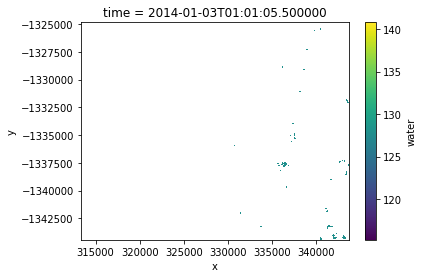

In [267]:
plt.clf()
wofs.water.isel(time=0).plot()
plt.show()

In [ ]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

In [ ]:

#Remove all values that are not defined as "wet water" (value of 128)
wofs128=wofs_data
wofs128['water']=wofs_data.water.where(wofs_data.water==128)

#Add water values for each pixel and turn into a percentage

#Add the water value for each pixel in the array over time
wofs128_v2 = wofs128.sum(dim = 'time')

#Take the average of water value at each pixel and turn into a percentage
wofs128_v2 = wofs128_v2/ 128
wofs128_v2 = wofs128_v2 / len(wofs128.time)
wofs128_v2 = wofs128_v2
return wofs128_v2

### define Fractional Cover load function

In [6]:
#ls5_fc_albers_staging

In [7]:
#def load_fc(sensor,query,bands_of_interest): 
def load_fc(sensor,query): 
    '''loads fractional cover data for a sensor, masks using pq, then filters out terrain -999s
    function written 22-11-2017 based on dc v1.5.3 BexDunn
    You may need to remove the staging flag in the name string when FC is in the DEA
    '''  
    dataset = []
    product_name = '{}_{}_albers_staging'.format(sensor, 'fc')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            ###CHECKME - fractional cover nodata values are -1
            ds=ds.where(ds!=-1)
            
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

## Functions to calculate count of exceedence of fractional cover

##### set thresholds here for green, bare

In [108]:
def calc_bare_soil_overthresh(fc,threshold=50.0):
    '''Calculate bare soil fraction values where bare soil fraction> set threshold. Inputs are fc array with BE and threshold value, 
    default threshold is 50. Band for baresoil>threshold is added to fc. This is not the count. xarray returns original array with bare_soil_over_threshold added'''
    if fc is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            fc['bare_soil_over_threshold'] = fc.BS.where(fc.BS>threshold)
            print('thresholded bare_soil added to array')
            return fc
    else:
        print('did not calculate bare_soils over threshold' )
        return None  

In [171]:
def calc_green_veg_overthresh(fc,threshold=20.0):
    '''Calculate green_veg fraction values where green_veg fraction> set threshold. Inputs are fc array with PV and threshold value, 
    default threshold is 20. Band for green_veg>threshold is added to fc. This is not the count. xarray returns original array with green_veg_over_threshold added'''
    if fc is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            fc['green_veg_over_threshold'] = fc.PV.where(fc.PV>threshold)
            print('thresholded green_veg added to array')
            return fc
    else:
        print('did not calculate green_veg over threshold' )
        return None  

### define function to calculate count of exceedence

In [164]:
def count_fc_1sensor(over_threshold_array, fc_type, fc_type_over_threshold):
    '''count the number of fc-flagged scenes for each pixel,
    count the amount of times that fc value is above the set threshold
    return a dictionary of total count and threshold count
    ###FIXME currently only runs over 1 sensor!!!'''
    if over_threshold_array is not None:
        #count the number of flagged scenes for each pixel
        total_count = over_threshold_array[fc_type].count(dim='time')

        #count the amount of times that fc is above the threshold
        threshold_count= over_threshold_array[fc_type_over_threshold].count(dim='time')
       
        #define dictionary of total count and threshold count
        counts = {'total count':total_count, 'threshold count':threshold_count}
 
##(bare_over_thresh['bare_soil_over_threshold'].count(dim='time')/bare_over_thresh['BS'].count(dim='time')).plot()

        count_of_ex = (counts['threshold count']/counts['total count'])
        print('counted')
        return count_of_ex, counts
    else:
        print('did not count')
        return None      

### function to write netcdf

In [8]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

#### save netcdf outputs to this folder:

In [210]:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/'

#### code to work with a polygon input

In [10]:
#code to work with a polygon input
#shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/Kevin.shp')
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/arafura_sml.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
i =0 
print('shapefile index is '+str(i))
if i > len(shapes):
    print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

shapefile index is 0


### set up the datacube query

In [11]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-wofs-fc')

#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

# #Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
# bands_of_interest = ['blue',
#                      'green',
#                      'red',
#                      'nir',
#                      'swir1',
#                      'swir2'
#                      ]

#define measurements of interest. Be aware of nodata values (-1)
measurements_of_interest = ['BS','PV','NPV','UE']


query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

### Load data for each sensor and apply cloud and terrain filters

## pull in fractional cover for the same query as nbart

In [12]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
#sensor1_fc=load_fc('ls5',query,bands_of_interest)
#sensor2_fc=load_fc('ls7',query,bands_of_interest)
sensor3_fc=load_fc('ls8',query)

loading ls8_fc_albers_staging
loaded ls8_fc_albers_staging
making mask ls8_pq_albers
masked ls8_fc_albers_staging with ls8_pq_albers and filtered terrain


## Plot fractional cover for one time slice to check the data

In [49]:
#Choose a time to plot to check the data
timechosen=78

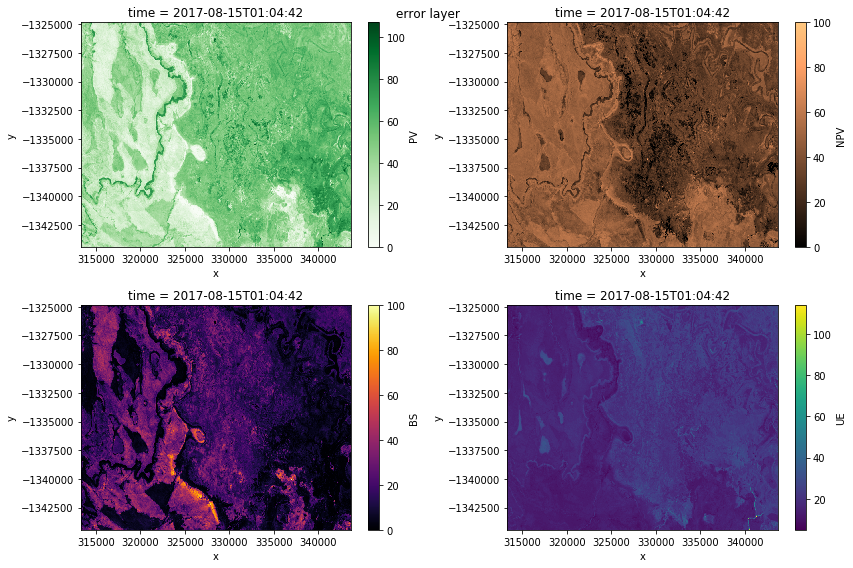

In [201]:
plt.clf()
plt.figure(figsize=(12,8))
#set up a grid of 3 images for better presentation
gs = gridspec.GridSpec(2,2)
#fig =plt.figure(figsize =(9,3))

#_______________________________________________________________#
ax1=plt.subplot(gs[0,0])
sensor3_fc.PV.isel(time=timechosen).plot(cmap='Greens')

ax2=plt.subplot(gs[1,0])
sensor3_fc.BS.isel(time=timechosen).plot(cmap='inferno')

ax3=plt.subplot(gs[0,1])
sensor3_fc.NPV.isel(time=timechosen).plot(cmap='copper',vmax=100,vmin=0)

ax4=plt.subplot(gs[1,1])
plt.suptitle('error layer')
sensor3_fc.UE.isel(time=timechosen).plot()

plt.tight_layout()
plt.show()

## Load wofs data

In [181]:
#get wofs
wofs = load_wofs(query)

In [253]:
wofs

<xarray.Dataset>
Dimensions:  (time: 153, x: 1216, y: 783)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-03T01:01:05.500000 ...
  * y        (y) float64 -1.325e+06 -1.325e+06 -1.325e+06 -1.325e+06 ...
  * x        (x) float64 3.133e+05 3.134e+05 3.134e+05 3.134e+05 3.134e+05 ...
Data variables:
    water    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

## calculate wofs proportion

In [254]:
wofs.water.flags_definition

{'cloud': {'bits': 6,
  'description': 'Cloudy',
  'values': {'0': False, '1': True}},
 'cloud_shadow': {'bits': 5,
  'description': 'Cloud shadow',
  'values': {'0': False, '1': True}},
 'dry': {'bits': [7, 6, 5, 4, 3, 1, 0],
  'description': 'No water detected',
  'values': {'0': True}},
 'high_slope': {'bits': 4,
  'description': 'High slope',
  'values': {'0': False, '1': True}},
 'nodata': {'bits': 0, 'description': 'No data', 'values': {'1': True}},
 'noncontiguous': {'bits': 1,
  'description': 'At least one EO band is missing over over/undersaturated',
  'values': {'0': False, '1': True}},
 'sea': {'bits': 2, 'description': 'Sea', 'values': {'0': False, '1': True}},
 'terrain_or_low_angle': {'bits': 3,
  'description': 'terrain shadow or low solar angle',
  'values': {'0': False, '1': True}},
 'wet': {'bits': [7, 6, 5, 4, 3, 1, 0],
  'description': 'Clear and Wet',
  'values': {'128': True}}}

In [184]:
wofs_drop = wofs.where(wofs.time == sensor3_fc.time)
wofs_proportion = wofs_water_only(wofs)

## Plot wofs proportion

In [262]:
wofs_proportion.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    water    float64 0.0

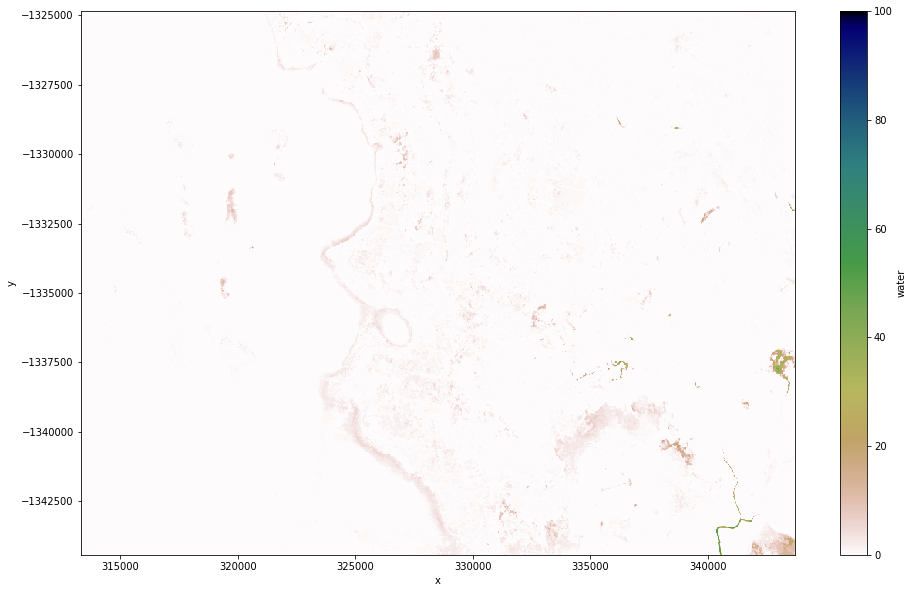

In [255]:
plt.clf()
plt.figure(figsize=(16,10))
wofs_proportion.water.plot(cmap='gist_earth_r',vmin=0, vmax=100)
plt.show()

In [250]:
wofs_proportion.water

<xarray.DataArray 'water' (y: 783, x: 1216)>
array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,   0.      ],
       ..., 
       [  0.      ,   0.      ,   0.      , ...,  12.418301,   7.843137,
          4.575163],
       [  0.      ,   0.      ,   0.      , ...,  11.764706,   9.803922,
          5.228758],
       [  0.      ,   0.      ,   0.      , ...,  14.379085,  10.457516,
          7.189542]])
Coordinates:
  * x        (x) float64 3.133e+05 3.134e+05 3.134e+05 3.134e+05 3.134e+05 ...
  * y        (y) float64 -1.325e+06 -1.325e+06 -1.325e+06 -1.325e+06 ...

## Calculate fractional cover bare soil count of exceedence 

In [138]:
bare_over_thresh =calc_bare_soil_overthresh(sensor3_fc)

thresholded bare_soil added to array


In [166]:
bare_count_of_ex_sensor3,bcounts_sensor_3_fc = count_fc_1sensor(bare_over_thresh,'BS','bare_soil_over_threshold')

counted


## Plot bare soil count of exceedence

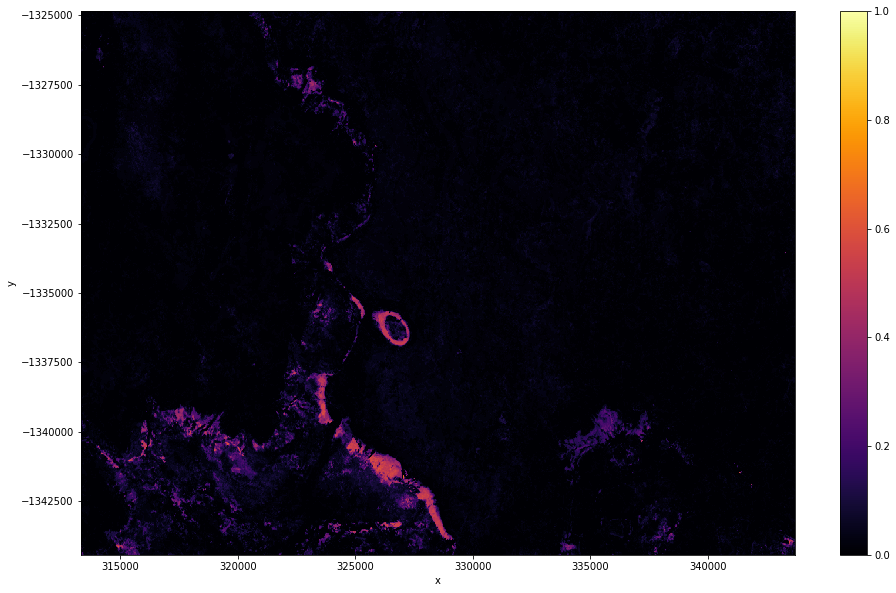

In [169]:
plt.clf()
plt.figure(figsize=(16,10))
bare_count_of_ex_sensor3.plot(cmap='inferno',vmin=0, vmax=1)
plt.show()

## Calculate photosynthetic vegetation count of exceedence

In [173]:
green_overthresh = calc_green_veg_overthresh(sensor3_fc)

thresholded green_veg added to array


In [176]:
green_veg_count_of_ex_sensor3,gcounts_sensor_3_nbart = count_fc_1sensor(green_overthresh, 'PV','green_veg_over_threshold')

counted


## Plot green_veg count of exceedence

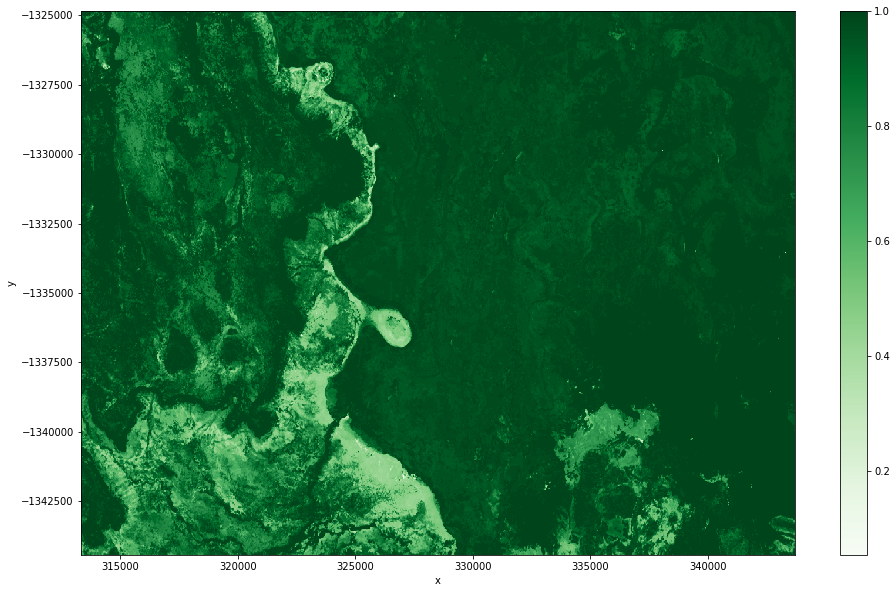

In [177]:
plt.clf()
plt.figure(figsize=(16,10))
green_veg_count_of_ex_sensor3.plot(cmap='Greens')
plt.show()

In [230]:
# if sensor1_nbart is not None:
#     crs = sensor1_nbart.crs
# else:
#     if sensor2_nbart is not None:
#         crs = sensor2_nbart.crs
#     else: 
crs = sensor3_fc.crs
print(crs) 

EPSG:3577


## Write out CoE arrays to netcdf

##### choose filenames and check where we are saving our files

In [231]:
print(netcdf_output_loc)

/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/


In [232]:
# #check if the file has already been written:
filenamestart = netcdf_output_loc+shape_name
print (filenamestart)

/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/arafura_sml_0


In [233]:
#option to add date range to filename
filenamestart_epoch=filenamestart+'_'+start_of_epoch+'_'+end_of_epoch

In [234]:
filenamestart_epoch

'/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/arafura_sml_0_2014-01-01_2017-12-31'

In [238]:
write_your_netcdf(wofs_proportion.water,'tcw_ls8',filename=filenamestart_epoch+'_wofs_coe_s3'+'.nc', crs=crs)

In [245]:
write_your_netcdf(bare_count_of_ex_sensor3,'tcb_ls8',filename=filenamestart_epoch+'_bare_soil_coe_s3'+'.nc', crs=crs)

In [246]:
write_your_netcdf(green_veg_count_of_ex_sensor3,'tcg_ls8',filename=filenamestart_epoch+'_green_veg_coe_s3'+'.nc', crs=crs)

RuntimeError: Storage Unit already exists: /g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/arafura_sml_0_2014-01-01_2017-12-31_green_veg_coe_s3.nc


In [247]:
os.chdir(netcdf_output_loc)

In [248]:
os.listdir()

['arafura_sml_0_2014-01-01_2017-12-31_bare_soil_coe_s3.nc',
 'arafura_sml_0_2014-01-01_2017-12-31_bare__soil_coe_s3.nc',
 'arafura_sml_0_2014-01-01_2017-12-31_green_veg_coe_s3.nc',
 'arafura_sml_0_2014-01-01_2017-12-31_wofs_coe_s3.nc',
 'arafura_sml_0_2014-01-01_2017-12-31_bare_coe_s3.nc']